In [1]:
import sys
sys.path.append('..')

In [2]:
import planetengine
from planetengine import quickShow

In [3]:
import underworld as uw
from underworld import function as fn
import math
import numpy as np

from planetengine.utilities import Grouper

In [32]:
def build(
        res = 64,
        f = 0.9,
        aspect = 4.,
        periodic = False,
        strength = 2.,
        Ra = 1e7,
        ):

    inputs = locals().copy()
    # script = __file__

    ### MESH & MESH VARIABLES ###

    f = max(0.00001, min(0.99999, f))
    inputs['f'] = f

    length = 1.
    outerRad = 1. / (1. - f)
    radii = (outerRad - length, outerRad)

    maxAspect = math.pi * sum(radii) / length
    aspect = min(aspect, maxAspect)
    inputs['aspect'] = aspect
    if aspect == maxAspect:
        periodic = True
        inputs['periodic'] = periodic

    width = length**2 * aspect * 2. / (radii[1]**2 - radii[0]**2)
    midpoint = math.pi / 2.
    angExtentRaw = (midpoint - 0.5 * width, midpoint + 0.5 * width)
    angExtentDeg = [item * 180. / math.pi for item in angExtentRaw]
    angularExtent = [
        max(0., angExtentDeg[0]),
        min(360., angExtentDeg[1] + abs(min(0., angExtentDeg[0])))
        ]
    angLen = angExtentRaw[1] - angExtentRaw[0]

    radRes = max(4, int(res / 4) * 4)
    inputs['res'] = radRes
    angRes = 4 * int(angLen * (int(radRes * radii[1] / length)) / 4)
    elementRes = (radRes, angRes)

    mesh = uw.mesh.FeMesh_Annulus(
        elementRes = elementRes,
        radialLengths = radii,
        angularExtent = angularExtent,
        periodic = [False, periodic]
        )

    ### SWARM ###

    swarm = uw.swarm.Swarm(mesh = mesh, particleEscape = True)
    swarm.populate_using_layout(
        uw.swarm.layouts.PerCellSpaceFillerLayout(
            swarm, 12
            )
        )

    repopulator = uw.swarm.PopulationControl(
        swarm,
        aggressive = True,
        splitThreshold = 0.15,
        maxDeletions = 2,
        maxSplits = 10,
        particlesPerCell = 10
        )

    ### VARIABLES ###

    pressureField = uw.mesh.MeshVariable(mesh.subMesh, 1)
    velocityField = uw.mesh.MeshVariable(mesh, 2)

    materialVar = swarm.add_variable(dataType = "int", count = 1)

    ### BOUNDARIES ###

    inner = mesh.specialSets["inner"]
    outer = mesh.specialSets["outer"]
    sides = mesh.specialSets["MaxJ_VertexSet"] + mesh.specialSets["MinJ_VertexSet"]

    if periodic:
        velBC = uw.conditions.RotatedDirichletCondition(
            variable = velocityField,
            indexSetsPerDof = (inner + outer, None),
            basis_vectors = (mesh.bnd_vec_normal, mesh.bnd_vec_tangent)
            )
    else:
        velBC = uw.conditions.RotatedDirichletCondition(
            variable = velocityField,
            indexSetsPerDof = (inner + outer, sides),
            basis_vectors = (mesh.bnd_vec_normal, mesh.bnd_vec_tangent)
            )

    ### SPECIAL ###

    # Needed for annulus to work properly
    vc = uw.mesh.MeshVariable(mesh = mesh, nodeDofCount = 2)
    vc_eqNum = uw.systems.sle.EqNumber(vc, False )
    vcVec = uw.systems.sle.SolutionVector(vc, vc_eqNum)

    ### FUNCTIONS ###

    depthFn = mesh.radialLengths[1] - mesh.radiusFn

    angExtentsRadians = np.array(mesh.angularExtent) * np.pi / 180.
    radWidth = angExtentsRadians[1] - angExtentsRadians[0]
    xFn, yFn = fn.input()[0], fn.input()[1]
    magnitudeFn = fn.math.sqrt(fn.math.pow(xFn, 2) + fn.math.pow(yFn, 2))
    rawAngFn = angFn = - 2. * fn.math.atan(yFn / ((magnitudeFn) + xFn))
    angFn = (rawAngFn + angExtentsRadians[1]) / radWidth

    angMag = fn.math.dot(mesh.unitvec_theta_Fn, vc)
    radMag = fn.math.dot(mesh.unitvec_r_Fn, vc)

    coolingFn = 1.

    matDensityFn = fn.branching.map(
        fn_key = materialVar,
        mapping = {
            0: fn.math.log(depthFn + 1.) + 1.,
            1: 2.,
            }
        )

    densityFn = Ra * matDensityFn

    ## RHEOLOGY ###

    matViscFn = fn.branching.map(
        fn_key = materialVar,
        mapping = {
            0: fn.math.log(2. - depthFn) + 1.,
            1: strength,
            }
        )

    viscosityFn = matViscFn

    ### SYSTEMS ###

    stokes = uw.systems.Stokes(
        velocityField = velocityField,
        pressureField = pressureField,
        conditions = [velBC,],
        fn_viscosity = viscosityFn,
        fn_bodyforce = mesh.unitvec_r_Fn * -densityFn,
        _removeBCs = False,
        )

    solver = uw.systems.Solver(stokes)

    advector = uw.systems.SwarmAdvector(
        swarm = swarm,
        velocityField = vc,
        order = 2,
        )

    step = fn.misc.constant(0)
    modeltime = fn.misc.constant(0.)

    ### SOLVING ###

    def postSolve():
        # realign solution using the rotation matrix on stokes
        uw.libUnderworld.Underworld.AXequalsY(
            stokes._rot._cself,
            stokes._velocitySol._cself,
            vcVec._cself,
            False
            )
        # remove null space - the solid body rotation velocity contribution
        uw.libUnderworld.StgFEM.SolutionVector_RemoveVectorSpace(
            stokes._velocitySol._cself, 
            stokes._vnsVec._cself
            )

    def solve():
        velocityField.data[:] = 0.
        solver.solve(
            nonLinearIterate = False,
            callback_post_solve = postSolve,
            )
        uw.libUnderworld.Underworld.AXequalsX(
            stokes._rot._cself,
            stokes._velocitySol._cself,
            False
            )

    def integrate():
        vc.data[:] -= (coolingFn * mesh.unitvec_r_Fn).evaluate(mesh)
        dt = advector.get_max_dt()
        advector.integrate(dt)
        repopulator.repopulate()
        modeltime.value += dt
        step.value += 1

    def iterate():
        integrate()
        solve()

    ### HOUSEKEEPING: IMPORTANT! ###

#     varsOfState = {'lithoField': lithoField}

    return Grouper(locals())

In [40]:
system = build(
    res = 32,
    Ra = 1e4,
    strength = 1e3,
    aspect = 1.,
    f = 1.,
    )

In [41]:
# quick and dirty initialise:
initialVar = system.mesh.add_variable(1)
initialMaterialFn = fn.branching.conditional([
    (initialVar > 0.5, 1),
    (True, 0)
    ])
boxDims = ((0., 1.),) * system.mesh.dim
box = planetengine.mapping.box(system.mesh, system.mesh.data, boxDims)
initialVar.data[:] = (1. - planetengine.initials.sinusoidal.IC().evaluate(box))**10.
system.materialVar.data[:] = initialMaterialFn.evaluate(system.swarm)

In [42]:
system.solve()

In [43]:
show = lambda: quickShow(
    system.densityFn,
    system.velocityField,
    system.viscosityFn,
    system.materialVar,
    resolution = (2048, 1024)
    )

Fitted 4 variables to the figure.



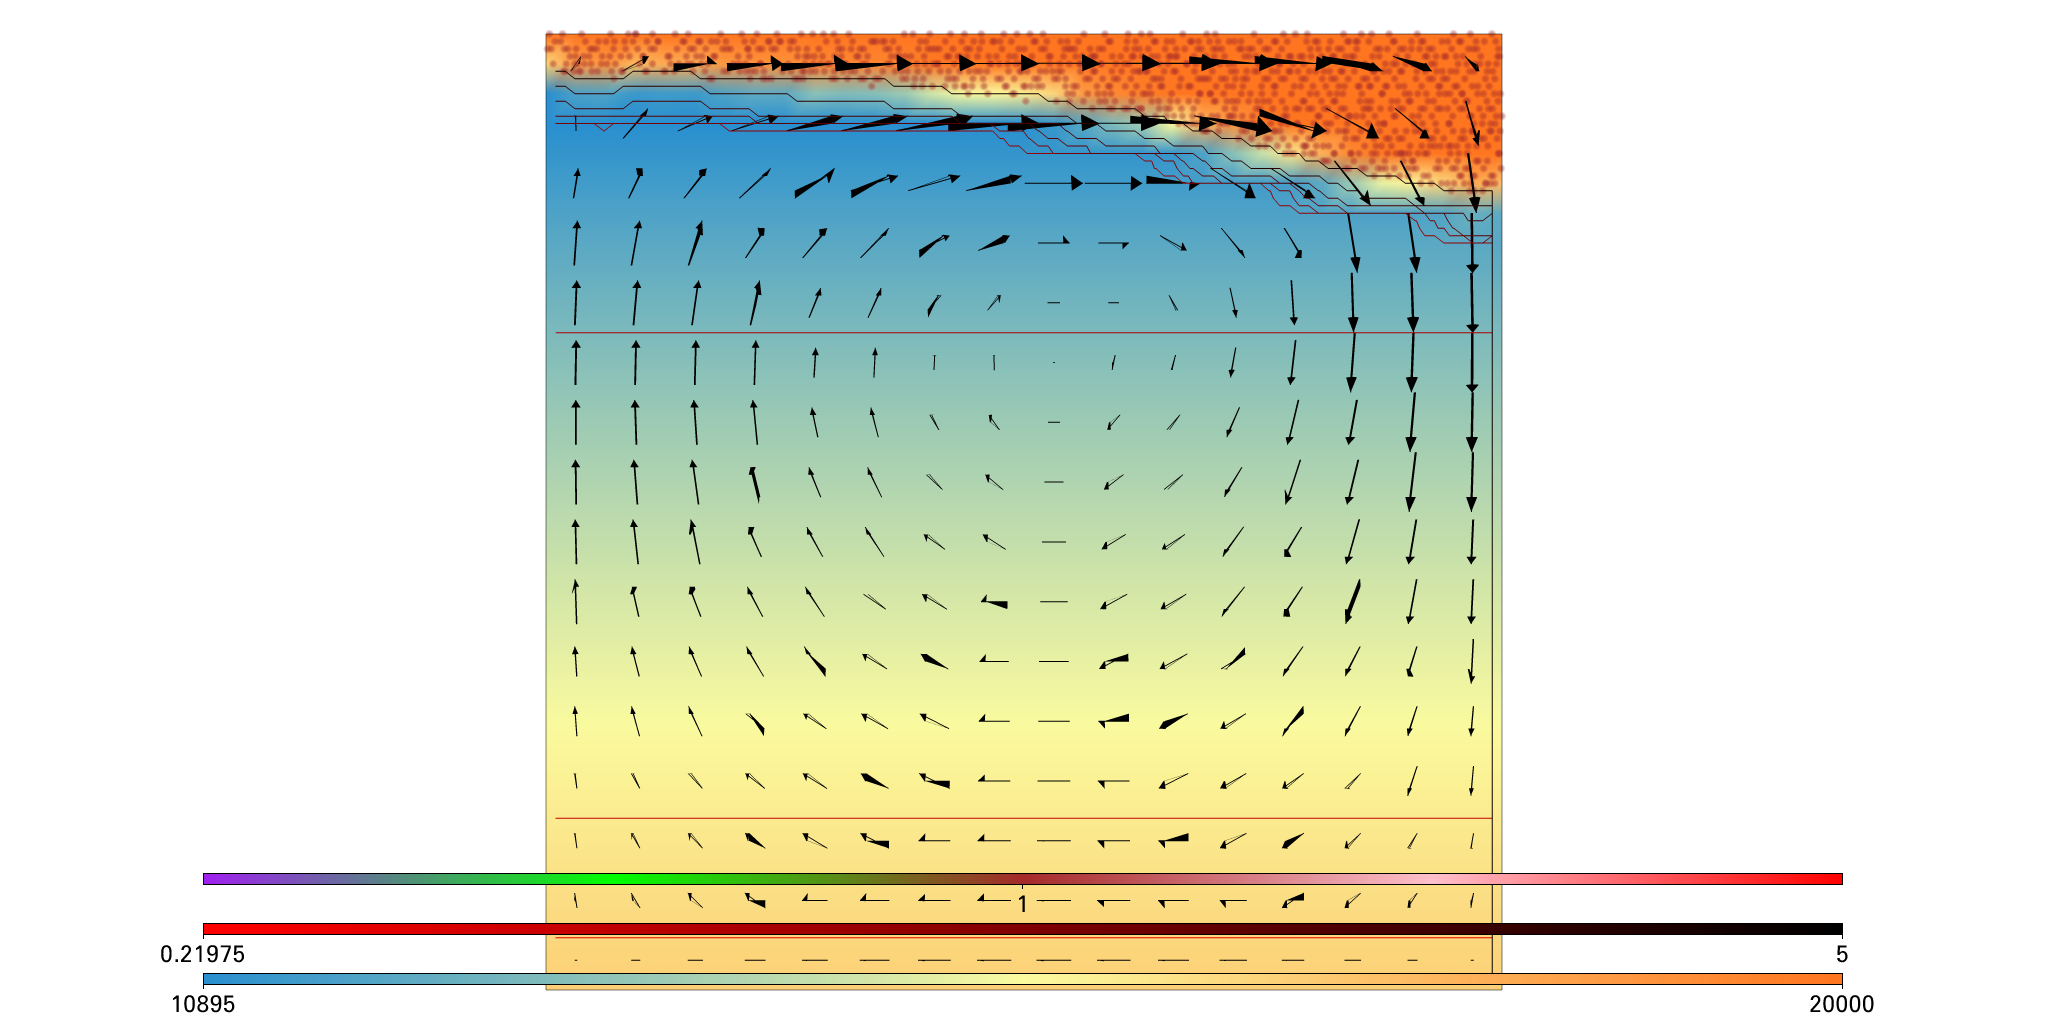

In [44]:
show()

Iteration 0
Fitted 4 variables to the figure.



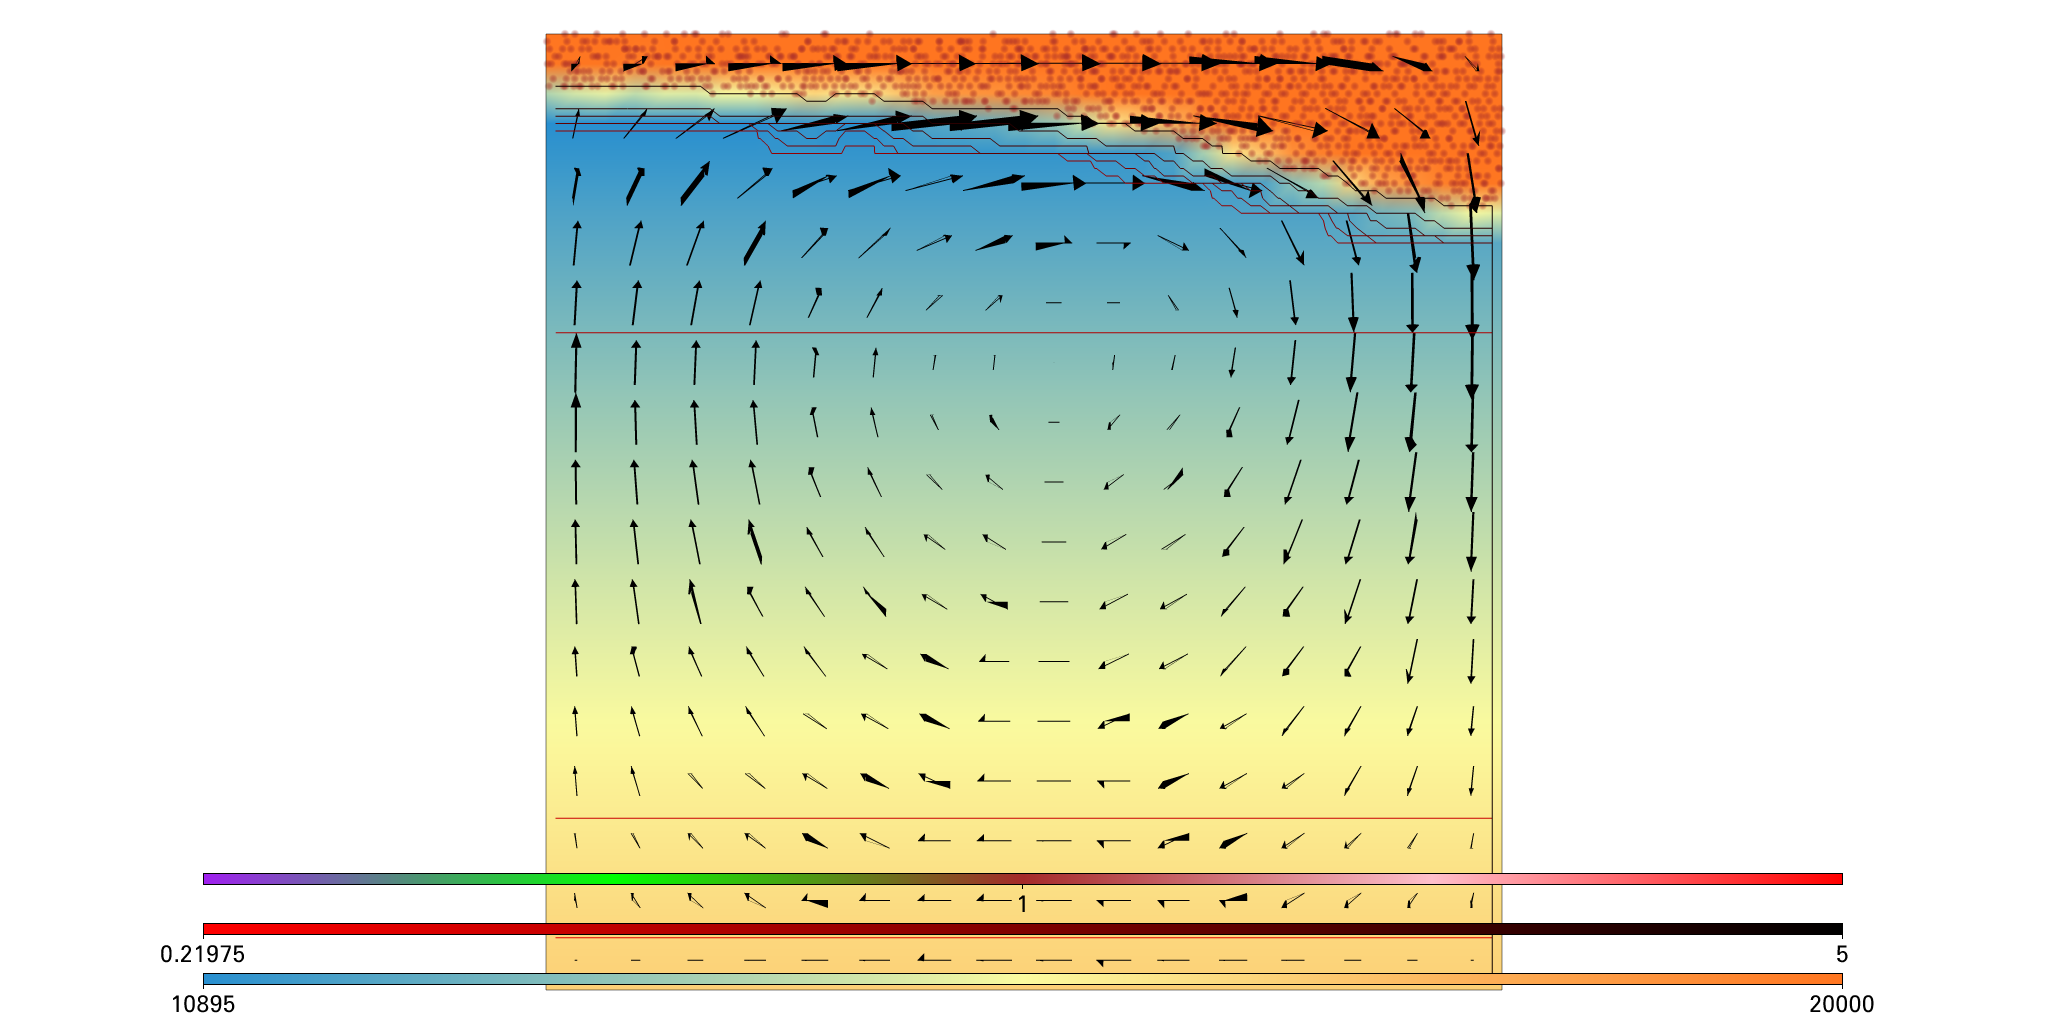

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Fitted 4 variables to the figure.



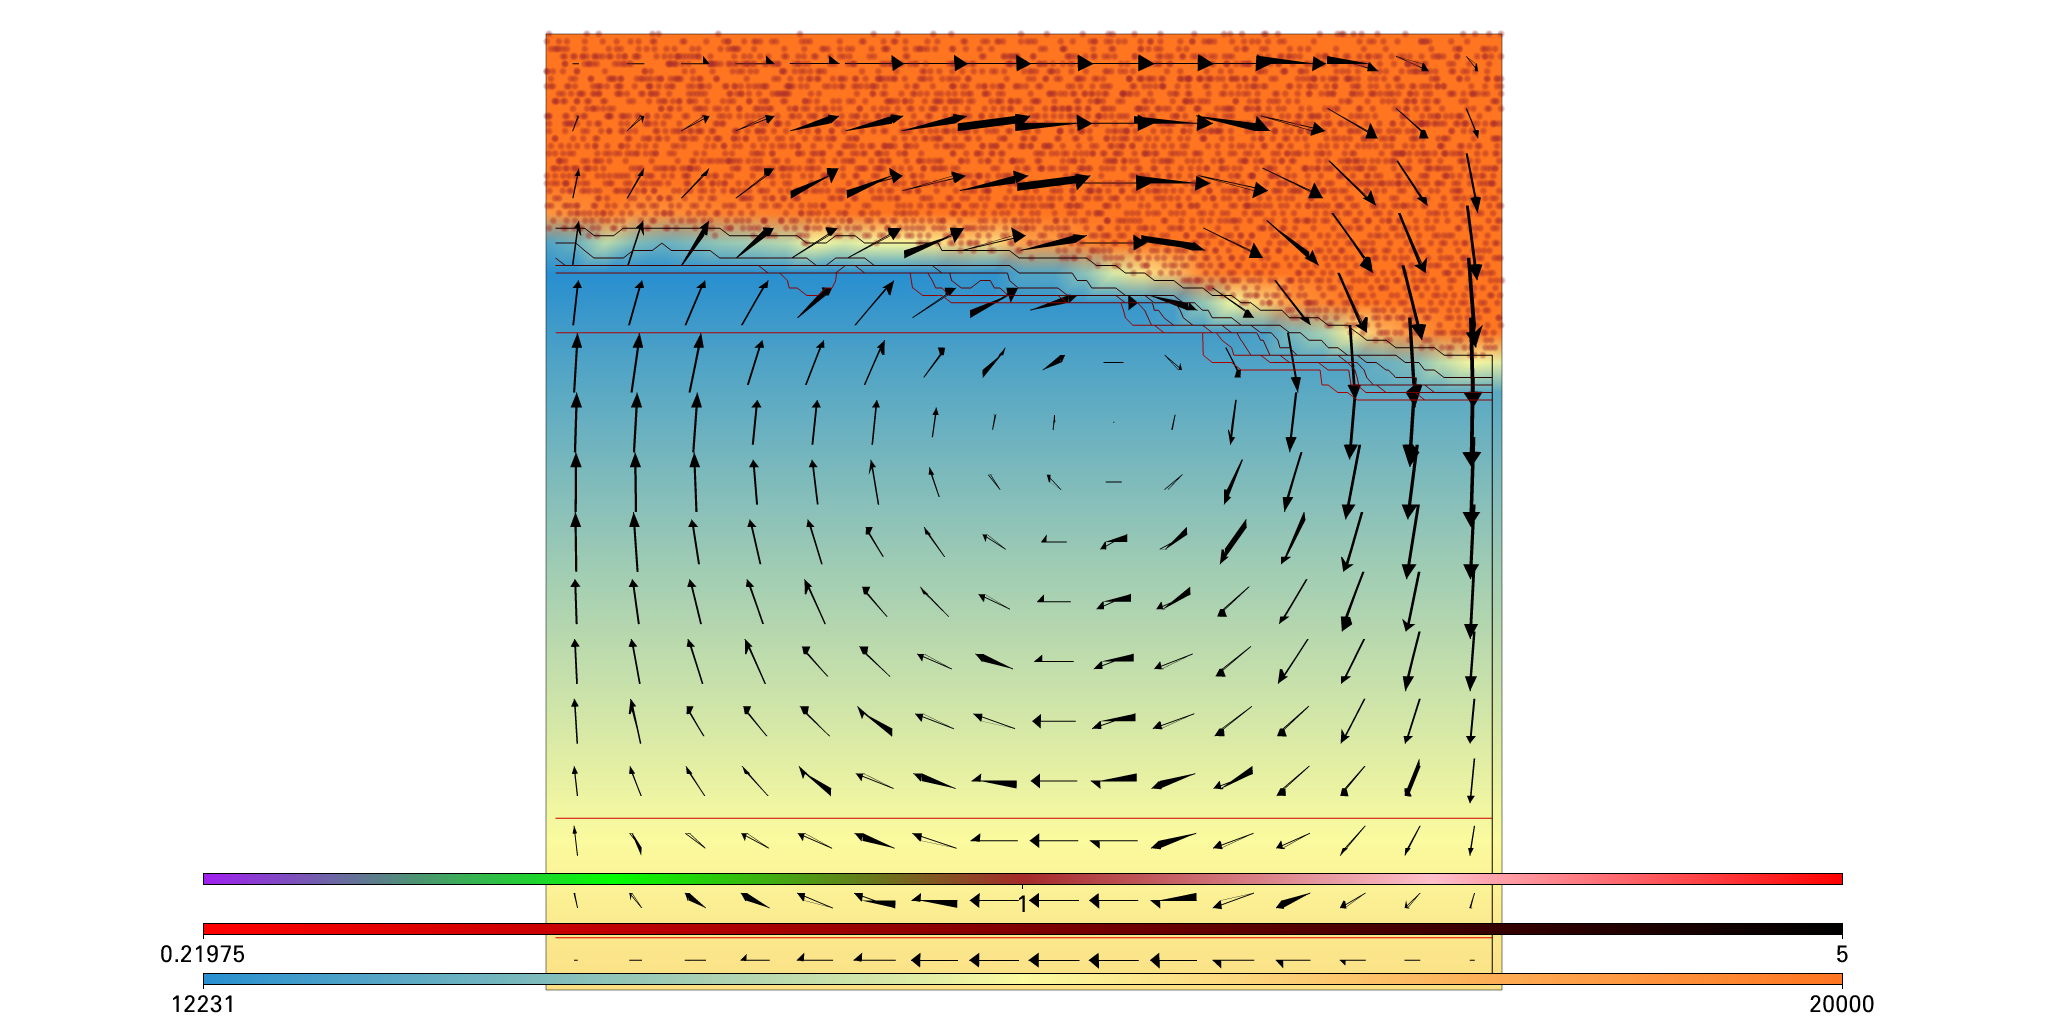

Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Fitted 4 variables to the figure.



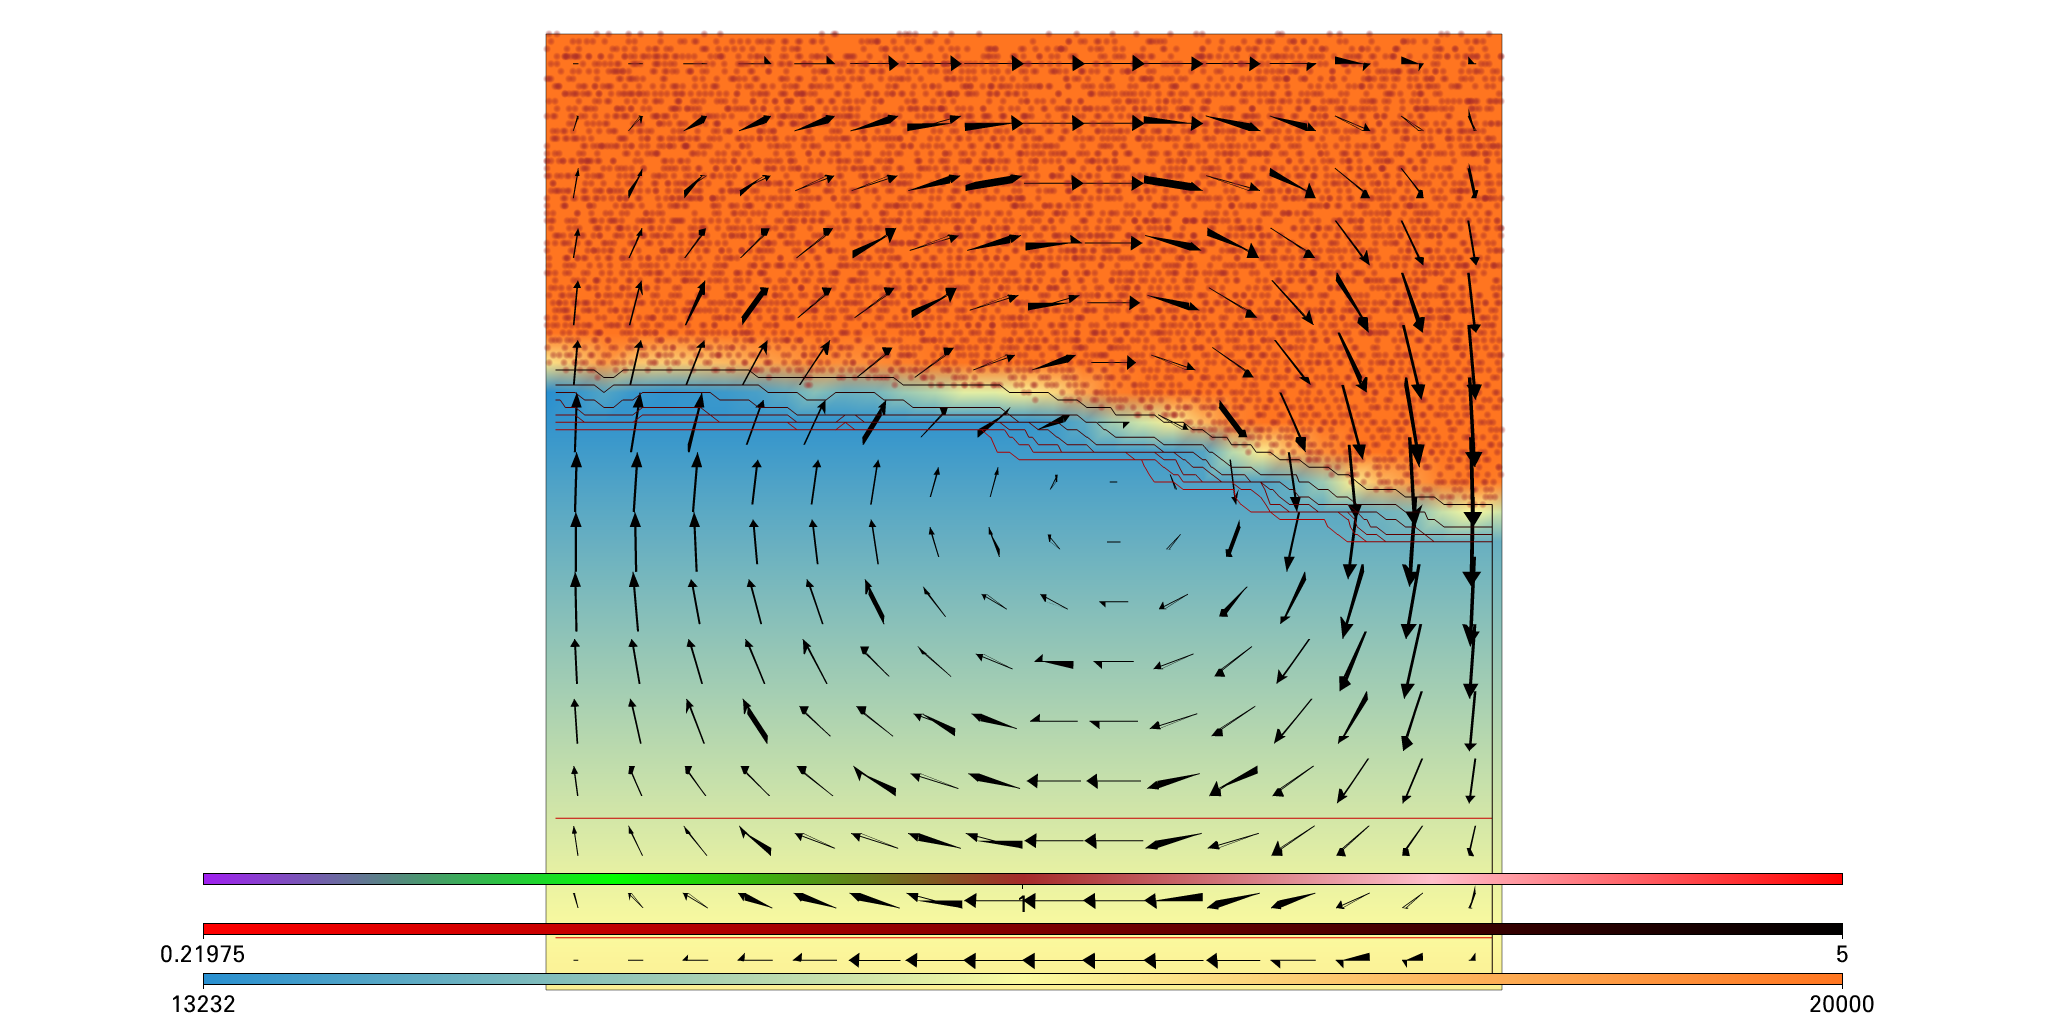

Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29


RuntimeError: Error encountered. Full restart recommended as exception safety not guaranteed. Error message:
Something went wrong in _PCDVC_Calculate2D: Problem has an under resolved cell (Cell Id = 543).
You may need to check your initial particle layout configuration. A per cell layout might give better results than a global layout, especially where you have a deformed mesh. Also, if particles are allowed to escape the domain, you will need to set the 'particleEscape=True' swarm constructor parameter, and likely also the 'aggressive=True' population control constructed parameter.

In [45]:
for i in range(100):
    system.iterate()
    print("Iteration " + str(i))
    if i % 10 == 0:
        show()
print("Done!")
show()